In [1]:
# connexion a wrds 
import wrds
db = wrds.Connection()

WRDS recommends setting up a .pgpass file.
pgpass file created at C:\Users\Gabri\AppData\Roaming\postgresql\pgpass.conf
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


In [ ]:
# IMPORTS
import wrds
import pandas as pd
import numpy as np  # pour np.random.choice

np.random.seed(42)  # pour reproductibilité

# --- 1️ Connexion WRDS ---
def connect_wrds():
    print(">>> Connexion WRDS...")
    db = wrds.Connection()
    print(">>> Connexion WRDS OK.\n")
    return db

# --- 2️ Échantillon aléatoire de 50 entreprises S&P500 ---
def get_sp500_sample(df, db):
    """
    Retourne un échantillon de 50 tickers du S&P500 avec EPS disponibles.
    df : dataframe initial CRSP (permno + ticker)
    db : connexion WRDS
    """
    import numpy as np
    np.random.seed(42)  # reproductibilité

    # Tickres uniques
    unique_tickers = df["ticker"].dropna().unique()

    # Vérifier quels tickers ont des données EPS
    valid_tickers = []
    for ticker in unique_tickers:
        query = f"""
            SELECT 1
            FROM comp.fundq
            WHERE tic = '{ticker}'
            LIMIT 1
        """
        result = db.raw_sql(query)
        if not result.empty:
            valid_tickers.append(ticker)

    print(f">>> {len(valid_tickers)} tickers ont au moins un EPS disponible.")

    # Échantillon aléatoire de 50 tickers
    if len(valid_tickers) < 50:
        print("Attention : moins de 50 tickers avec EPS, on prend tout ce qui est disponible.")
        sample_tickers = valid_tickers
    else:
        sample_tickers = np.random.choice(valid_tickers, size=50, replace=False)

    # Construire le dataframe final (ticker + permno)
    sample = df[df["ticker"].isin(sample_tickers)][["permno", "ticker"]].drop_duplicates()

    print(f">>> Échantillon final : {len(sample['ticker'].unique())} tickers sélectionnés.")
    return sample


# --- 3️ Extraction des prix CRSP ---
def get_prices(db, sample):
    permno_list = "', '".join(sample['permno'].astype(str).unique())
    query = f"""
        SELECT date, prc, permno
        FROM crsp.dsf
        WHERE permno IN ('{permno_list}')
        ORDER BY permno, date
    """
    prices = db.raw_sql(query)
    print(">>> Prix téléchargés.\n")
    return prices

# --- 4️ Extraction des EPS Compustat ---
def get_eps(db, sample):
    tic_list = "', '".join(sample['ticker'].unique())
    query = f"""
        SELECT gvkey, tic AS ticker, datadate, epspxq
        FROM comp.fundq
        WHERE tic IN ('{tic_list}')
        ORDER BY gvkey, datadate
    """
    eps = db.raw_sql(query)
    print(">>> EPS téléchargés.\n")
    return eps

# --- 5️ Jointure CRSP ↔ EPS via ticker ---
def merge_prices_eps(prices, eps, sample):
    merged = prices.merge(sample, on='permno', how='left')
    merged = merged.merge(eps, on='ticker', how='left')
    
    # Filtrer EPS publié avant la date du prix
    merged = merged[merged['datadate'] <= merged['date']]
    print(">>> Jointure CRSP + EPS effectuée.\n")
    return merged

# --- 6️ Calcul Trailing P/E ---
def compute_trailing_PE(merged):
    merged = merged.sort_values(['permno', 'date'])
    merged['eps_ttm'] = merged.groupby('permno')['epspxq'].rolling(4).sum().reset_index(level=0, drop=True)
    merged['eps_ttm'] = merged.groupby('permno')['eps_ttm'].ffill()
    merged['trailing_pe'] = merged['prc'] / merged['eps_ttm']
    print(">>> Trailing EPS & P/E calculés.\n")
    return merged

# --- 7️ Pipeline complet ---
def run_pipeline():
    db = connect_wrds()

    # Charger la liste S&P500 depuis CRSP
    df = db.raw_sql("""
        SELECT permno, ticker
        FROM crsp.msenames
        WHERE shrcd IN (10,11)
        AND exchcd IN (1,2,3)
    """)

    sample = get_sp500_sample(df, db)
    prices = get_prices(db, sample)
    eps = get_eps(db, sample)

    merged = merge_prices_eps(prices, eps, sample)
    final = compute_trailing_PE(merged)
    
    # Filtrer pour les dates après 2003
    final['date'] = pd.to_datetime(final['date'])
    final = final[final['date'] > "2003-01-01"]

    print(final.head())
    return final

# --- 8️ Exécution ---
if __name__ == "__main__":
    final_df = run_pipeline()
    final_df.to_csv("SP500_trailing_PE.csv", index=False)
    print(">>> Pipeline terminé, CSV sauvegardé.\n")


>>> Connexion WRDS...
WRDS recommends setting up a .pgpass file.
pgpass file created at C:\Users\Gabri\AppData\Roaming\postgresql\pgpass.conf
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done
>>> Connexion WRDS OK.

>>> 13487 tickers ont au moins un EPS disponible.
>>> Échantillon final : 50 tickers sélectionnés.
>>> Prix téléchargés.

>>> EPS téléchargés.

>>> Jointure CRSP + EPS effectuée.

>>> Trailing EPS & P/E calculés.

              date   prc  permno ticker   gvkey    datadate  epspxq  eps_ttm  \
2903729 2003-01-02 -9.38   11647  ACMTA  001097  1981-03-31     0.1     1.13   
2903730 2003-01-02 -9.38   11647  ACMTA  001097  1981-06-30    0.15     0.94   
2903731 2003-01-02 -9.38   11647  ACMTA  001097  1981-09-30    0.34     0.91   
2903732 2003-01-02 -9.38   11647  ACMTA  001097  1981-12-31    0.08     0.67   
2903733 2003-01-02 -9.38   11647  ACMTA  001097  1982-03-31    0.14   

### Nettoyage et préparation des données

1. **Renommer les colonnes** pour plus de clarté : `prc → prix`, `epspxq → EPS`, `eps_ttm → EPS_MOBILE`, `trailing_pe → Prix_bene`.

2. **Trier et convertir les dates** par entreprise (`permno`) et date, supprimer colonnes temporaires inutiles.

3. **Filtrer les anciennes données** : garder uniquement les EPS à partir de 2003.

4. **Remplir les valeurs manquantes** (NaN) par forward/backfill par entreprise et supprimer les tickers avec >30% de NaN.

5. **Convertir en float** les colonnes `prix` et `EPS`.

6. **Supprimer doublons** par ticker et date, garder la dernière ligne.

7. **Préparer les données trimestrielles** : garder `permno`, `datadate`, `epspxq`, une seule ligne par trimestre et par entreprise.

8. **Calculer le BPA glissant sur 4 trimestres** (`EPS_MA4`) en moyenne des 4 derniers trimestres pour chaque entreprise.

9. **Fusionner les données journalières et trimestrielles** : associer à chaque ligne quotidienne le BPA glissant du dernier trimestre disponible (`merge_asof` avec `by='permno'`).

10. **Calculer les ratios prix/BPA** :  
    - Historique : `prix / EPS`  
    - Glissant : `prix / EPS_MA4`


In [188]:
# nettoyage et préparations des données 
def nettoyage_df(df):
    
    # par convention on prend la valeur des prix en absolue
    df['prc'] = df['prc'].abs()

    # par convention on prend la valeur des prix en absolue
    final_df['prc'] = final_df['prc'].abs()

    # Renommer les colonnes proprement
    df = df.rename(columns={
        "prc": "prix",
        "epspxq": "EPS",
        "eps_ttm": "EPS_MOBILE",
        "trailing_pe": "Prix_bene"
    })
    
    # Trier les données par entreprise et par date
    df = df.sort_values(['permno', 'date'])
    
    # Supprimer les colonnes temporaires
    df = df.drop(columns=['EPS_MOBILE', 'Prix_bene'])
    
    # Convertir les dates
    df['date'] = pd.to_datetime(df['date'])
    df['datadate'] = pd.to_datetime(df['datadate'])
    
    # Filtrer les EPS trop anciens : garder EPS >= 2003
    df = df[df['datadate'] >= "2003-01-01"]
    
    # Remplir les NaN dans EPS par forward-fill + backfill par permno
    df['EPS'] = df.groupby('permno')['EPS'].transform(lambda x: x.ffill().bfill())
    
    # Garder uniquement les tickers avec moins de 30% de NaN sur EPS
    nan_eps_pct = df.groupby('ticker')['EPS'].apply(lambda x: x.isna().mean())
    tickers_valides = nan_eps_pct[nan_eps_pct <= 0.30].index
    df = df[df['ticker'].isin(tickers_valides)]
    
    # Convertir les colonnes en float
    float_cols = ['prix', 'EPS']
    for col in float_cols:
        df[col] = pd.to_numeric(df[col])
    
    # Vérifier le type des colonnes
    print("Types de données :\n", df.dtypes)
    
    # Trier par ticker et date pour cohérence
    df = df.sort_values(['permno', 'date'], ascending=True).reset_index(drop=True)
    df = df.drop_duplicates(subset=['ticker', 'date'], keep='last')
    
    # défintion de df quarter 
    df_quarter = final_df[['permno', 'datadate', 'epspxq', "prc"]].dropna()

    # Convertir datadate en datetime si ce n’est pas déjà le cas
    df_quarter['datadate'] = pd.to_datetime(df_quarter['datadate'])

    # Garder une seule ligne par permno et trimestre
    df_quarter = df_quarter.sort_values(['permno', 'datadate'])
    df_quarter = df_quarter.drop_duplicates(subset=['permno', 'datadate'], keep='first')

    #  Calcul EPS mobile 4 trimestres
    df_quarter['EPS_MA4'] = (
        df_quarter
        .groupby('permno')['epspxq']
        .rolling(window=4, min_periods=4)
        .mean()
        .reset_index(level=0, drop=True)
    )

    # Trier globalement par date pour deux df
    df = df.sort_values('date').reset_index(drop=True)
    df_quarter = df_quarter.sort_values('datadate').reset_index(drop=True)

    #  Calcul prix mobile 4 trimestres
    df_quarter['prix_MA4'] = (
        df_quarter
        .groupby('permno')['prc']
        .rolling(window=4, min_periods=4)
        .mean()
        .reset_index(level=0, drop=True)
    )

    #  Merge des deux df
    df = pd.merge_asof(
        df,
        df_quarter[['permno', 'datadate', 'EPS_MA4', "prix_MA4"]],
        left_on='date',
        right_on='datadate',
        by='permno',
        direction='backward'
    )

    # Vérifier les dates min/max
    print("Date minimale :", df['date'].min())
    print("Date maximale :", df['date'].max())

    # Supprimer les lignes avec NaN
    df = df.dropna(subset=["EPS_MA4"])

    # calcule du ratio p/b historique et glissant 
    df["ratio_pb_h"] = df["prix"] / df["EPS"] # histo 
    
    # merge 
    df["ratio_pb_MA"] = df["prix_MA4"] / df["EPS_MA4"] # glissant

    # présence de NaN par colone 
    df.isna().sum()

    # Supprimer les colonnes doublés 
    df = df.drop(columns=['datadate_y'])
    
    # Renommer la colone doublé 
    df = df.rename(columns={
        "datadate_x": "datadate"
    })

    # trie final par ticker et date 
    df = df.sort_values(["ticker", "date"]).reset_index(drop=True)

    # supression des NaN restant 
    df = df.dropna()

    # Filtrer les EPS trop anciens : garder EPS >= 2003
    df_quarter = df_quarter[df_quarter['datadate'] >= "2003-01-01"]

    return df, df_quarter

# résultats 
df, df_quarter = nettoyage_df(final_df)
df.tail() # visualisation des résultats 

Types de données :
 date        datetime64[ns]
prix               Float64
permno               Int64
ticker      string[python]
gvkey       string[python]
datadate    datetime64[ns]
EPS                Float64
dtype: object
Date minimale : 2003-03-31 00:00:00
Date maximale : 2024-12-31 00:00:00


,date,prix,permno,ticker,gvkey,datadate,EPS,EPS_MA4,prix_MA4,ratio_pb_h,ratio_pb_MA
69220,2024-12-24,135.03,90175,XPO,144998,2024-09-30,0.81,0.7950,104.902500,166.703704,131.952830
69221,2024-12-26,133.17,90175,XPO,144998,2024-09-30,0.81,0.7950,104.902500,164.407407,131.952830
69222,2024-12-27,132.25999,90175,XPO,144998,2024-09-30,0.81,0.7950,104.902500,163.283938,131.952830
69223,2024-12-30,132.59,90175,XPO,144998,2024-09-30,0.81,0.7950,104.902500,163.691358,131.952830
69224,2024-12-31,131.14999,90175,XPO,144998,2024-12-31,0.65,0.8325,116.469998,201.769215,139.903901


c:\Users\Gabri\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Gabri\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4671: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


          prix                                                              \
         count        mean         std     min       25%      50%      75%   
ticker                                                                       
ACMTA    425.0   11.825264    1.655929    7.76     11.39   12.375     12.7   
ANVS    1240.0   15.619605   16.758745     2.5    6.8475    11.68    15.25   
BMTC    4724.0    27.70186    9.053802   12.68     20.94   23.865  33.8575   
COSN     558.0    4.778236    2.006079    1.97    2.8225    4.735      6.3   
ESMT     588.0    20.60648     3.83128   15.44   18.1275    19.94   21.845   
FACE    1533.0    6.312403    5.365217     1.0       3.0     3.66     9.16   
FDBC    1820.0   51.563178    8.101955   32.01   46.1775     50.5   58.175   
GHLD    1054.0   13.077483    2.203606    7.96   11.0525    13.65    14.76   
HOTJ     541.0    1.828089    1.269812  0.0498       0.8     1.72     2.61   
IEX     5477.0   95.940493    69.04512   16.74     39.01    70.8

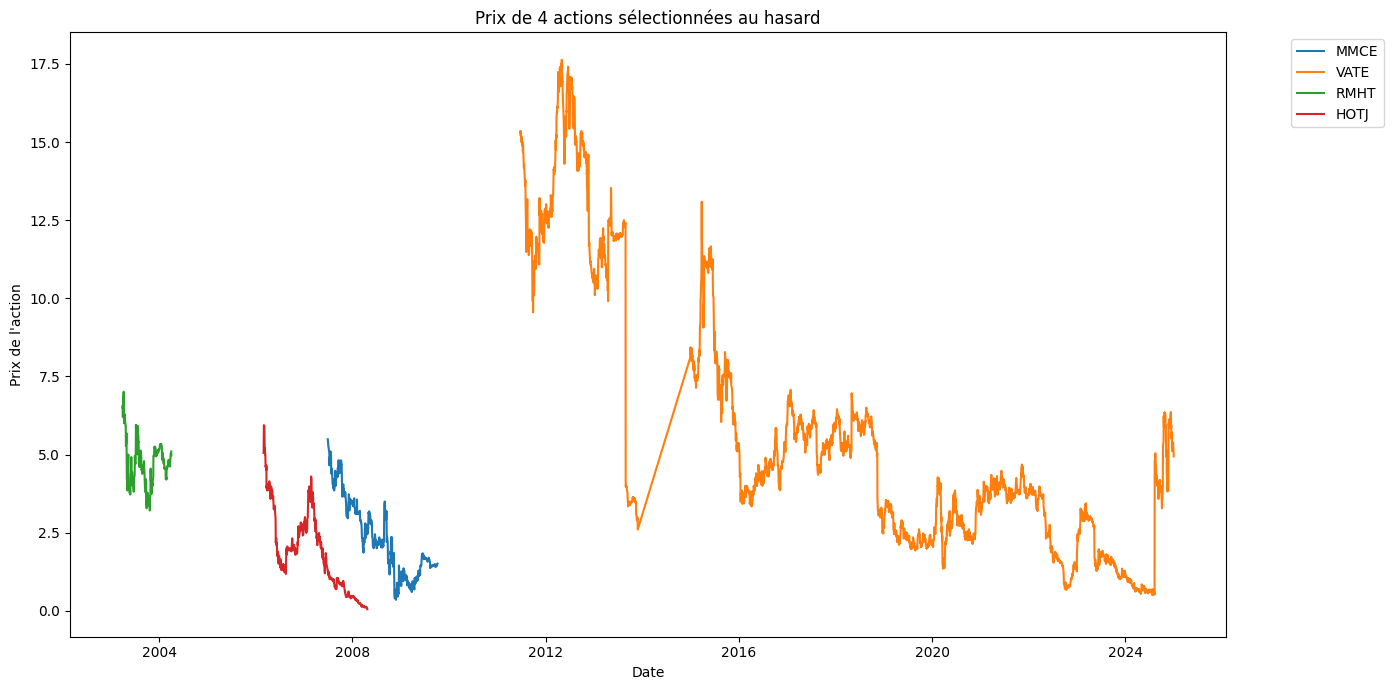

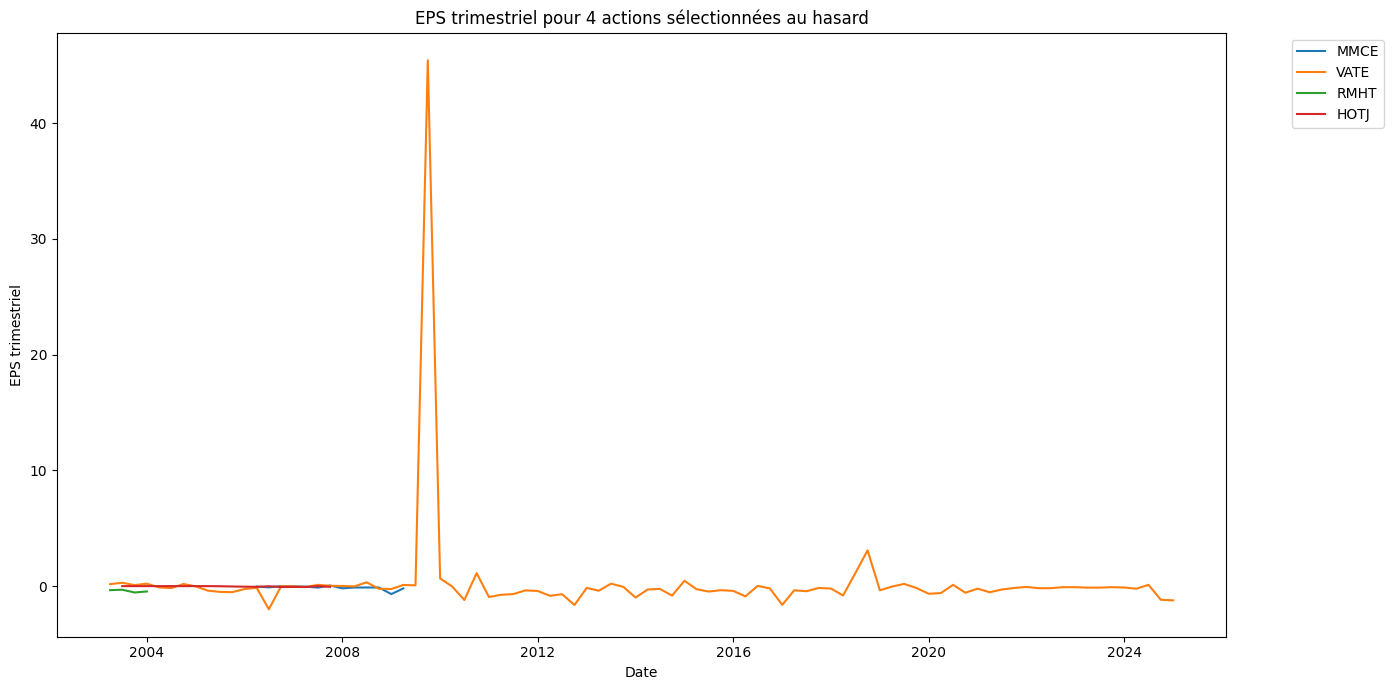

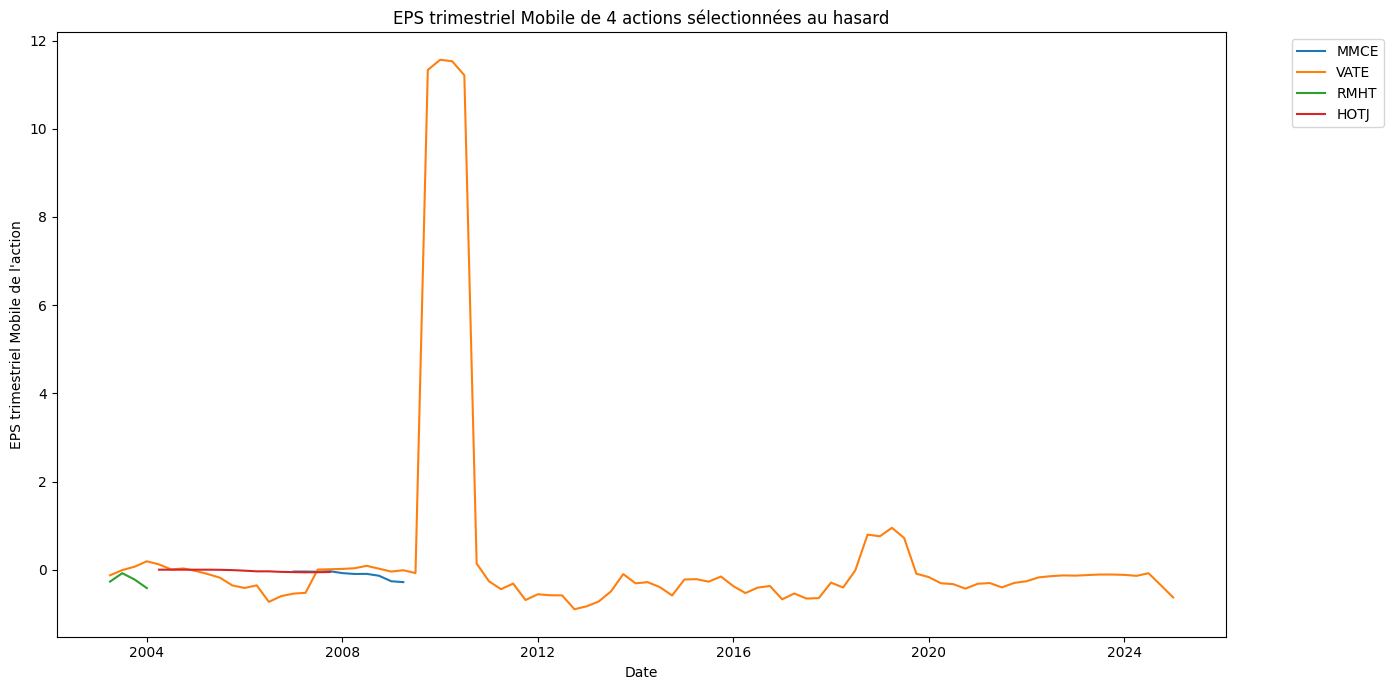

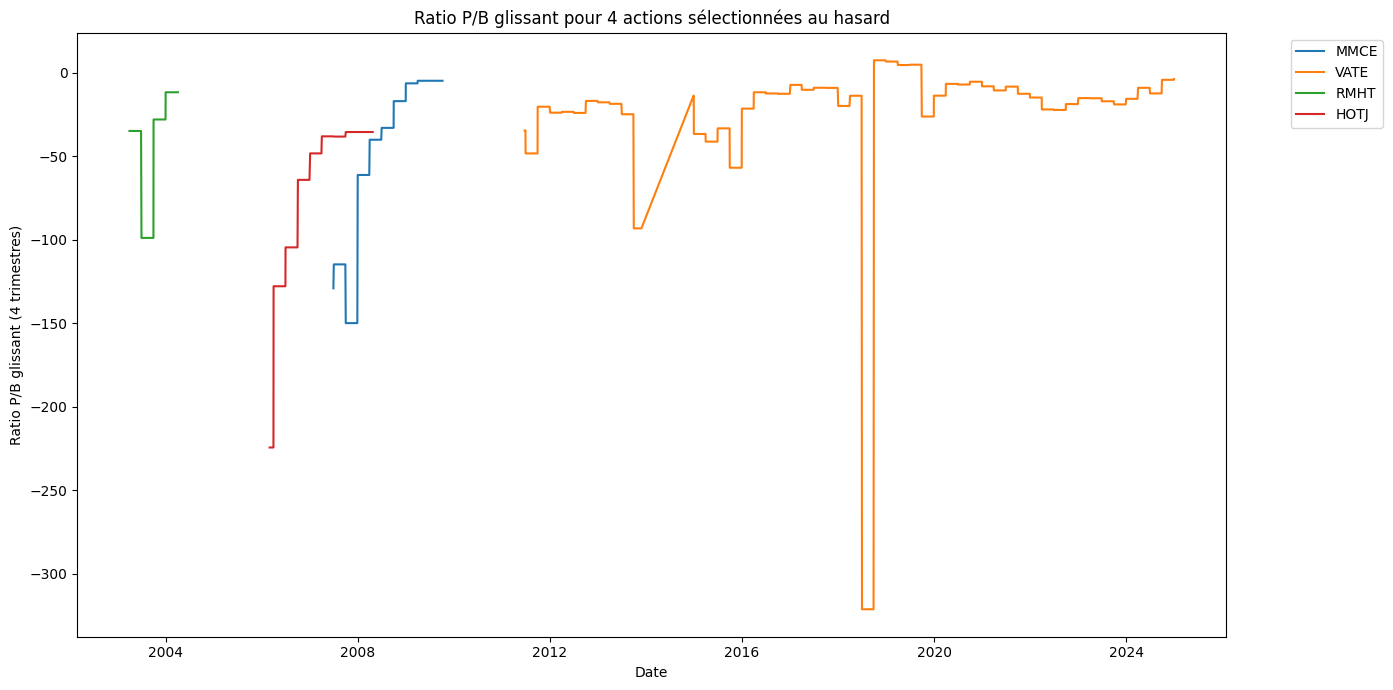

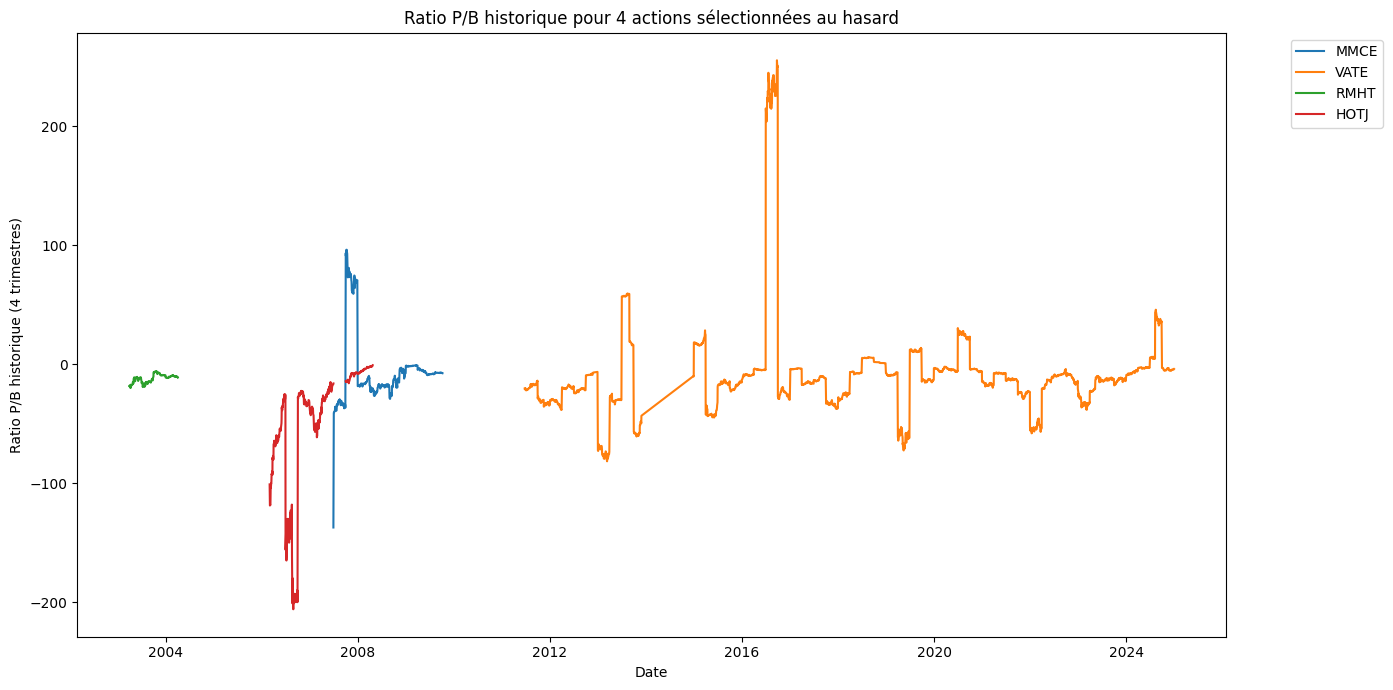

In [189]:
# statistique descriptives des colonnes sélectionnés (par actions)
stat_des = df.groupby("ticker")[['prix', 'EPS', 'ratio_pb_h', 'ratio_pb_MA']].describe()
print(stat_des)

# visualisation des graph de chaque séries 
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(4222)

# Sélectionner 4 tickers au hasard
tickers_unique = df['ticker'].unique()
tickers_alea = np.random.choice(tickers_unique, size=4, replace=False)

# graph de la série avec les prix 
plt.figure(figsize=(14, 7))
for t in tickers_alea:
    df_t = df[df['ticker'] == t]  # filtrer pour ce ticker
    plt.plot(df_t['date'], df_t['prix'], label=t)

plt.xlabel("Date")
plt.ylabel("Prix de l'action")
plt.title("Prix de 4 actions sélectionnées au hasard")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # légende à côté
plt.tight_layout()
plt.show()

# graph pour la série eps trimestriel 
# merge les permno au df quarter afin de pouvoir tracer le graph 
df_quarter = df_quarter.merge(df[['permno', 'ticker']].drop_duplicates(), on='permno', how='left')

plt.figure(figsize=(14, 7))
for t in tickers_alea:
    df_q = df_quarter[df_quarter['ticker'] == t]  # filtrer par ticker
    plt.plot(df_q['datadate'], df_q['epspxq'], label=t)

plt.xlabel("Date")
plt.ylabel("EPS trimestriel")
plt.title("EPS trimestriel pour 4 actions sélectionnées au hasard")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# graph de la série avec les eps mobile 
plt.figure(figsize=(14, 7))
for t in tickers_alea:
    df_q = df_quarter[df_quarter['ticker'] == t]  # filtrer par ticker
    plt.plot(df_q['datadate'], df_q['EPS_MA4'], label=t)

plt.xlabel("Date")
plt.ylabel("EPS trimestriel Mobile de l'action")
plt.title("EPS trimestriel Mobile de 4 actions sélectionnées au hasard")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # légende à côté
plt.tight_layout()
plt.show()

# graph pour le ratio p/b glissant 
plt.figure(figsize=(14, 7))
for t in tickers_alea:
    df_q = df[df['ticker'] == t]
    plt.plot(df_q['date'], df_q['ratio_pb_MA'], label=t)

plt.xlabel("Date")
plt.ylabel("Ratio P/B glissant (4 trimestres)")
plt.title("Ratio P/B glissant pour 4 actions sélectionnées au hasard")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# graph pour le ratio p/b historique 
plt.figure(figsize=(14, 7))
for t in tickers_alea:
    df_q = df[df['ticker'] == t]
    plt.plot(df_q['date'], df_q['ratio_pb_h'], label=t)

plt.xlabel("Date")
plt.ylabel("Ratio P/B historique (4 trimestres)")
plt.title("Ratio P/B historique pour 4 actions sélectionnées au hasard")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [190]:
# régression linéaire avec variable d'intéraction EPS*P/B
import numpy as np
import statsmodels.api as sm

# Créer la variable explicative (d'intéraction)
df["EPS_MA*ratio_pb_MA"] = df["EPS_MA4"] * df["ratio_pb_MA"]

# Remplacer tous les inf par NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Supprimer toutes les lignes où X ou Y sont NaN
df_clean = df.dropna(subset=["EPS_MA*ratio_pb_MA", "prix"])

# Forcer les types float64
df_clean["EPS_MA*ratio_pb_MA"] = df_clean["EPS_MA*ratio_pb_MA"].astype(float)
df_clean["prix"] = df_clean["prix"].astype(float)

# Sélectionner X et Y et ajouter la constante
X = sm.add_constant(df_clean[["EPS_MA*ratio_pb_MA"]].astype(float))
Y = df_clean["prix"].astype(float)

# Clusters en int
clusters = df_clean['permno'].astype(int)

# Vérification finale
print("NaN dans X :", X.isna().sum().sum())
print("NaN dans Y :", Y.isna().sum())
print("inf dans X :", np.isinf(X).sum())
print("inf dans Y :", np.isinf(Y).sum())

# Estimation OLS tranversale 
model_a = sm.OLS(Y, X).fit(cov_type='cluster', cov_kwds={'groups': clusters})
print(model_a.summary())



NaN dans X : 0
NaN dans Y : 0
inf dans X : const                 0
EPS_MA*ratio_pb_MA    0
dtype: int64
inf dans Y : 0
                            OLS Regression Results                            
Dep. Variable:                   prix   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     362.3
Date:                Fri, 21 Nov 2025   Prob (F-statistic):           8.71e-17
Time:                        17:31:12   Log-Likelihood:            -2.9436e+05
No. Observations:               68949   AIC:                         5.887e+05
Df Residuals:                   68947   BIC:                         5.887e+05
Df Model:                           1                                         
Covariance Type:              cluster                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
----

C:\Users\Gabri\AppData\Local\Temp\ipykernel_23736\1617264119.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["EPS_MA*ratio_pb_MA"] = df_clean["EPS_MA*ratio_pb_MA"].astype(float)
C:\Users\Gabri\AppData\Local\Temp\ipykernel_23736\1617264119.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["prix"] = df_clean["prix"].astype(float)


In [191]:
# Régression linéaire avec modèle naif 

# supression de potentiels NaN par précaution 
df = df.dropna()

#  --- modèle naif 1 ---  

# définition des variables 
X1 = sm.add_constant(df[["EPS_MA4"]]) # variable indépendante 
Y = df[["prix"]].astype(float) # variable dépendante 
clusters = df["permno"] # groupe 

# modèle (1) 
model_1 = sm.OLS(Y, X1).fit(cov_type='cluster', cov_kwds={'groups': clusters})

# --- modèle naif 2 --- 

# définiton des variables 
X2 = sm.add_constant(df[["ratio_pb_MA"]]) # variable indépendante 
Y = df[["prix"]].astype(float) # variable dépendante 
clusters = df["permno"] # groupe 

# modèle (2) 
model_2 = sm.OLS(Y, X2).fit(cov_type='cluster', cov_kwds={'groups': clusters})

# résultats des deux modèles naif 
print("Résultats modèle naif 1")
print(model_1.summary())
print("---")
print("\n")
print("---")
print("Résultats modèle naif 2")
print(model_2.summary())


Résultats modèle naif 1
                            OLS Regression Results                            
Dep. Variable:                   prix   R-squared:                       0.309
Model:                            OLS   Adj. R-squared:                  0.309
Method:                 Least Squares   F-statistic:                     26.06
Date:                Fri, 21 Nov 2025   Prob (F-statistic):           2.55e-05
Time:                        17:31:31   Log-Likelihood:            -3.8053e+05
No. Observations:               68509   AIC:                         7.611e+05
Df Residuals:                   68507   BIC:                         7.611e+05
Df Model:                           1                                         
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         31.6772      6

        prix  pred_model_1  pred_model_2  pred_model_3
55189   11.8     13.322022     23.270596     54.331507
55190  11.96     13.322022     23.270596     54.331507
55191  11.95     13.322022     23.270596     54.331507
55192  11.78     13.322022     23.270596     54.331507
55193  12.03     13.322022     23.270596     54.331507
EQMP Modèle 1 : 139.79604094100497
EQMP Modèle 2 : 722.3394845043576
EQMP Modèle 3 : 1310.390667919707


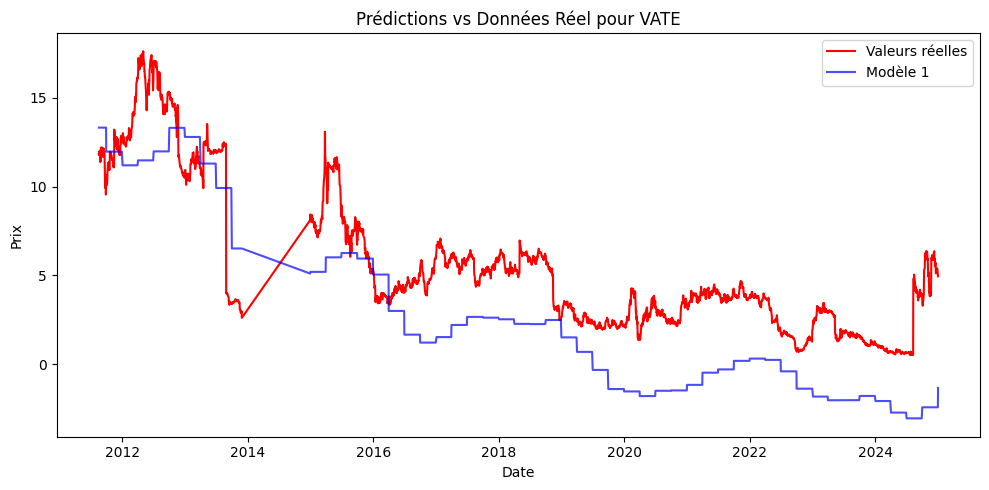

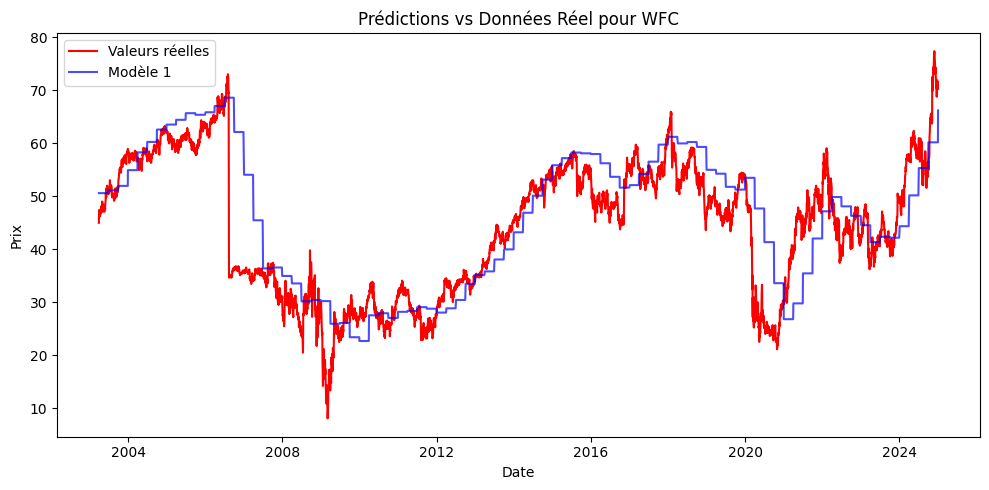

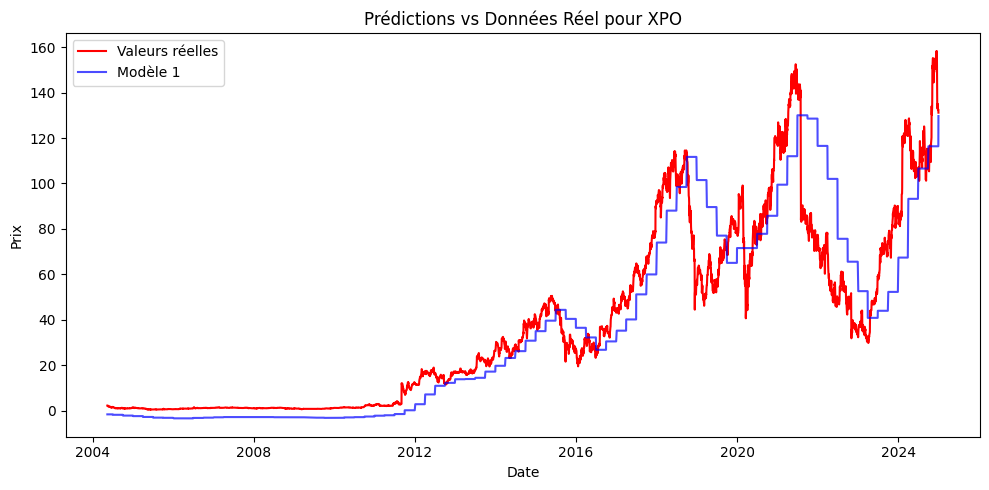

In [192]:
# division des données un deux groupes (entrainement et test)
n = int(len(df)*(0.80)) 
df_train = df.iloc[:n] # 80 % des données 
df_test = df.iloc[n:] # 20 % des données 

from sklearn.metrics import mean_squared_error

# fonction permettant de faire des forecast 
def forecast(df_train, df_test): 

    # enlève les potentiels NaN restants 
    df_train = df_train.dropna()
    df_test = df_test.dropna()
    
    # définission des variables indépendantes 
    X1 = sm.add_constant(df_train[["EPS_MA*ratio_pb_MA"]])
    X2 = sm.add_constant(df_train[["EPS_MA4"]])
    X3 = sm.add_constant(df_train[["ratio_pb_MA"]])
    clusters = df_train["permno"] # groupe 

    # définission de la variable dépendantes 
    Y = df_train[["prix"]]

    # estimation des modèles 
    model_1 = sm.OLS(Y, X1).fit(cov_type='cluster', cov_kwds={'groups': clusters})
    model_2 = sm.OLS(Y, X2).fit(cov_type='cluster', cov_kwds={'groups': clusters})
    model_3 = sm.OLS(Y, X3).fit(cov_type='cluster', cov_kwds={'groups': clusters})

    # utilisation des modèles sur les données de test (prévisions)
    # variable de test 
    X1_t = sm.add_constant(df_test[["EPS_MA*ratio_pb_MA"]])
    X2_t = sm.add_constant(df_test[["EPS_MA4"]])
    X3_t = sm.add_constant(df_test[["ratio_pb_MA"]])
    Y_t = df_test[["prix"]] # vrai valeur 
    
    # forcast 
    model_1_pred = model_1.predict(X1_t)
    model_2_pred = model_2.predict(X2_t)
    model_3_pred = model_3.predict(X3_t)

    # résultats 
    df_results = df_test.copy()
    df_results["pred_model_1"] = model_1_pred
    df_results["pred_model_2"] = model_2_pred
    df_results["pred_model_3"] = model_3_pred

    # afficher un extrait
    print(df_results[["prix", "pred_model_1", "pred_model_2", "pred_model_3"]].head())

    # EQMP pour chaque modèle
    eqmp_1 = mean_squared_error(Y_t, model_1_pred)
    eqmp_2 = mean_squared_error(Y_t, model_2_pred)
    eqmp_3 = mean_squared_error(Y_t, model_3_pred)

    print("EQMP Modèle 1 :", eqmp_1)
    print("EQMP Modèle 2 :", eqmp_2)
    print("EQMP Modèle 3 :", eqmp_3)

    return df_results

res = forecast(df_train, df_test)

# graphiques illustrants la différences entre les résultats du forcast et les données réelles 
for ticker in df_test["ticker"].unique():
    df_t = res[res["ticker"] == ticker].sort_values("date")
    
    plt.figure(figsize=(10,5))
    plt.plot(df_t["date"], df_t["prix"], label="Valeurs réelles", color="red")
    plt.plot(df_t["date"], df_t["pred_model_1"], label="Modèle 1", alpha=0.7, color="blue")
    
    plt.title(f"Prédictions vs Données Réel pour {ticker}")
    plt.xlabel("Date")
    plt.ylabel("Prix")
    plt.legend()
    plt.grid(False)
    plt.tight_layout()
    plt.show()

In [ ]:
# création de nouvelles varibales indicatrices 

# 1) taux de croissance loga du eps trimestriel 

# tri par ticker et date
df_quarter = df_quarter.sort_values(["ticker", "datadate"])

# calcul du taux de croissance log
df_quarter["log_croissance_eps"] = df_quarter.groupby("ticker")["epspxq"].transform(
    lambda x: np.log(x / x.shift(1))
)

# nettoyage des valeurs infinies et NaN
df_quarter["log_croissance_eps"] = df_quarter["log_croissance_eps"].replace([np.inf, -np.inf], np.nan)
df_quarter["log_croissance_eps"] = df_quarter["log_croissance_eps"].dropna()

# merge 

# trier avant merge_asof
df = df.sort_values(["date"])
df_quarter = df_quarter.sort_values(["datadate"])

df = pd.merge_asof(
    df,
    df_quarter[['permno', 'datadate', 'log_croissance_eps']],
    left_on='date',
    right_on='datadate',
    by='permno',
    direction='backward'
)

# 2) carré du taux de croissance loga du eps trimestriel 
df["log_croissance_eps_2"] = df["log_croissance_eps"] ** 2

# 3) moyenne des prix des 200 dernier jours 
df['prix_MA_200'] = df['prix'].rolling(window=200).mean()

# nettoyage du df 
df_3 = df 


c:\Users\Gabri\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\arrays\masked.py:672: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs2, **kwargs)
c:\Users\Gabri\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\arrays\masked.py:672: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs2, **kwargs)


In [180]:
df

,date,prix,permno,ticker,gvkey,datadate_x,EPS,EPS_MA4,ratio_pb_h,prix_MA4,ratio_pb_MA,EPS_MA*ratio_pb_MA,datadate_y,log_croissance_eps,log_croissance_eps_2,prix_MA_200
0,2003-04-03,8.12,11647,ACMTA,001097,2003-03-31,0.16,0.2975,50.75,8.167500,27.453782,8.167500,2003-03-31,<NA>,<NA>,NaN
1,2003-04-03,60.5,50876,LLY,006730,2003-03-31,0.38,0.5775,159.210526,58.897500,101.987013,58.897500,2003-03-31,<NA>,<NA>,NaN
2,2003-04-03,5.47,85020,PPBI,064979,2003-03-31,-0.19,0.4200,-28.789474,5.705000,13.583333,5.705000,2003-03-31,<NA>,<NA>,NaN
3,2003-04-03,36.29,86124,BMTC,016698,2003-03-31,0.66,0.6375,54.984848,35.715000,56.023529,35.715000,2003-03-31,<NA>,<NA>,NaN
4,2003-04-03,13.33,84319,LAD,064175,2003-03-31,0.24,0.4200,55.541667,12.722500,30.291667,12.722500,2003-03-31,<NA>,<NA>,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68423,2024-12-31,3.5101,21551,UPXI,038661,2024-12-31,-1.24,-0.5800,-2.830726,3.755025,-6.474181,3.755025,2024-12-31,2.74084,7.512204,122.377544
68424,2024-12-31,4.94,12877,VATE,063952,2024-12-31,-1.23,-0.6300,-4.01626,5.162500,-8.194444,5.162500,2024-12-31,0.0415,0.001722,121.479144
68425,2024-12-31,70.24,38703,WFC,008007,2024-12-31,1.45,1.3600,48.441379,70.880000,52.117647,70.880000,2024-12-31,0.013889,0.000193,121.693844
68426,2024-12-31,106.08,72996,SF,011770,2024-12-31,2.26,1.6675,46.938053,106.652500,63.959520,106.652500,2024-12-31,0.45769,0.20948,122.199744
